In [2]:
#zFL_=xr.DataArray(patchDataL[:,:,0],dims=['nrec','npix'])
#zetaFL_=xr.DataArray(patchDataL[:,:,1],dims=['nrec','npix'])
#sfcPrecip_hb_=xr.DataArray(patchDataL[:,:,2],dims=['nrec','npix'])
#pType_=xr.DataArray(patchDataL[:,:,3],dims=['nrec','npix'])
#piaFinal_=xr.DataArray(patchDataL[:,:,4],dims=['nrec','npix'])
#sfcPrecip_=xr.DataArray(patchDataL[:,:,5],dims=['nrec','npix'])
#patchData_=xr.DataArray(patchDataL,dims=['nrec','npix','nvar'])

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

with nc.Dataset("patchData.nc") as f:
    patchData = f.variables['patchData'][:]

In [31]:
patchData[:,:,0][patchData[:,:,0]<0]=0
print(patchData[:,:,5].min())
for i in range(6):
    print(patchData[:,:,i].max(axis=1).mean(),patchData[:,:,i].min(axis=1).mean(),i)
nt=patchData.shape[0]
dpia=np.random.randn(nt,10,10)*2
xdata=np.zeros((patchData.shape[0],10,10,5))
xdata[:,:,:,0]=(patchData[:,:,0].reshape(nt,10,10)-20)/10
xdata[:,:,:,1]=np.log10(1+patchData[:,:,1].reshape(nt,10,10)/100.)
xdata[:,:,:,2]=np.log10(1+patchData[:,:,2].reshape(nt,10,10)/10.)
xdata[:,:,:,3]=patchData[:,:,3].reshape(nt,10,10)
piaN=patchData[:,:,4].reshape(nt,10,10)+dpia
piaN[piaN<0]=0
xdata[:,:,:,4]=np.log10(1+piaN/10.)

ydata=np.log10(1+patchData[:,:,5].mean(axis=1)/10.)

y_hb=np.log10(1+patchData[:,:,2].mean(axis=1)/10.)



0.0
32.21044157293584 0.8150176109768111 0
5482.270385064962 79.10996947502059 1
13.278254012809187 0.011654603160635954 2
2.6962777604003754 0.09557873549931321 3
2.280054430183103 0.00708301350495799 4
11.131822047797755 0.014545227379363496 5


In [32]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest, y_hb_train, y_hb_test = train_test_split(xdata, ydata, y_hb, test_size=0.2, random_state=42)


In [14]:
#define tensorflow convnet that predicts y from x
import tensorflow as tf
from tensorflow import keras    
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import utils

def convnet():
    inputs = keras.Input(shape=(10,10,5))
    x = layers.Conv2D(16, 3, activation="relu")(inputs)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs=inputs, outputs=outputs)

model = convnet()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 10, 5)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 16)          736       
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                36896     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33  

In [37]:
#model = convnet()
#model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xtest,ytest), verbose=1)

Epoch 1/10
1839/1839 [==============================] - 4s 2ms/step - loss: 2.0032e-04 - mse: 2.0032e-04 - mae: 0.0079 - val_loss: 2.7576e-04 - val_mse: 2.7576e-04 - val_mae: 0.0089
Epoch 2/10
1839/1839 [==============================] - 4s 2ms/step - loss: 1.9269e-04 - mse: 1.9269e-04 - mae: 0.0078 - val_loss: 1.4408e-04 - val_mse: 1.4408e-04 - val_mae: 0.0069
Epoch 3/10
1839/1839 [==============================] - 4s 2ms/step - loss: 1.9054e-04 - mse: 1.9054e-04 - mae: 0.0077 - val_loss: 8.3675e-05 - val_mse: 8.3675e-05 - val_mae: 0.0054
Epoch 4/10
1839/1839 [==============================] - 4s 2ms/step - loss: 1.9787e-04 - mse: 1.9787e-04 - mae: 0.0078 - val_loss: 7.9082e-05 - val_mse: 7.9082e-05 - val_mae: 0.0052
Epoch 5/10
1839/1839 [==============================] - 4s 2ms/step - loss: 2.0233e-04 - mse: 2.0233e-04 - mae: 0.0078 - val_loss: 6.9399e-05 - val_mse: 6.9399e-05 - val_mae: 0.0050
Epoch 6/10
1839/1839 [==============================] - 4s 2ms/step - loss: 1.8890e-04 - m

460/460 [==============================] - 0s 675us/step


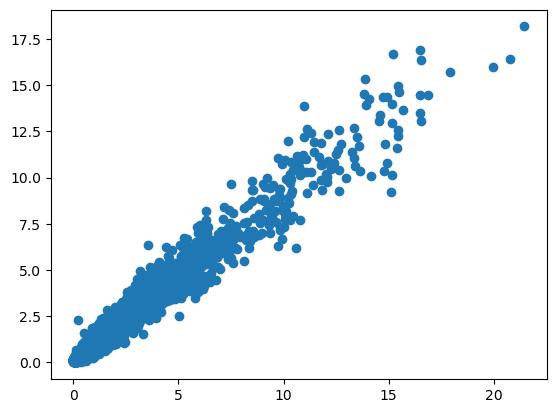

In [38]:
y_pred=model.predict(xtest)
y_nat=10*(np.power(10,ytest)-1)
y_pred_nat=10*(np.power(10,y_pred)-1)
plt.scatter(y_nat,y_pred_nat)

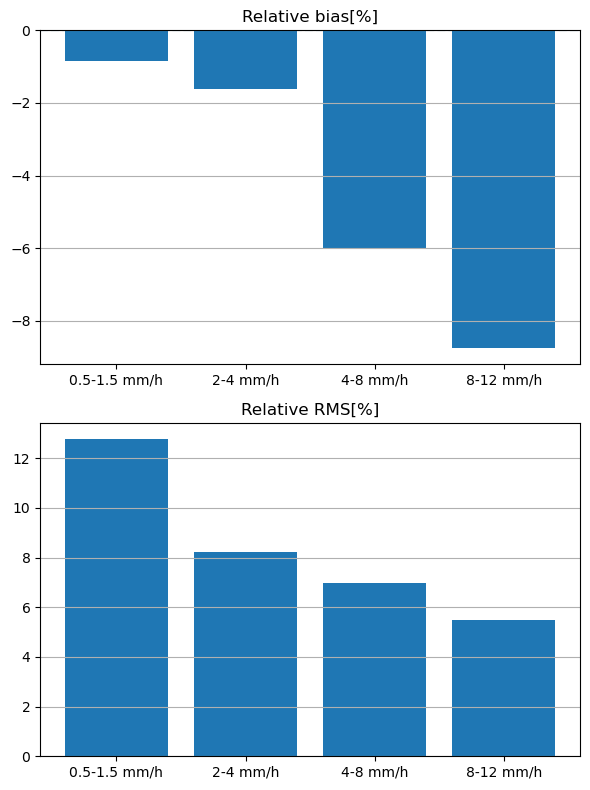

In [39]:
evalInt=[[0.5,1.5],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
y_test,y_predLGBM=y_nat,y_pred_nat
for int1 in evalInt:
    a=np.nonzero((y_test>=int1[0]) & (y_test<int1[1]))
    bias=np.mean(y_predLGBM[a]-y_test[a])/np.mean(y_test[a])
    rms=np.sqrt(np.mean((y_predLGBM[a]-y_test[a])**2))/np.mean(y_test[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0.5-1.5 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100*0.25)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('convNetKuPR.png')

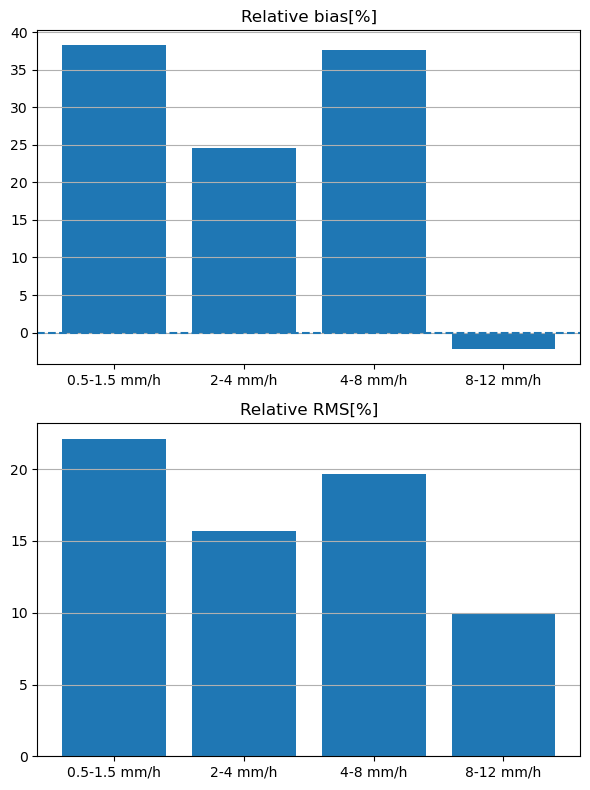

In [40]:
evalInt=[[0.5,1.5],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
y_hb_nat=10*(10**y_hb_test-1)
y_test,y_predLGBM=y_nat,y_hb_nat
for int1 in evalInt:
    a=np.nonzero((y_test>=int1[0]) & (y_test<int1[1]))
    bias=np.mean(y_predLGBM[a]-y_test[a])/np.mean(y_test[a])
    rms=np.sqrt(np.mean((y_predLGBM[a]-y_test[a])**2))/np.mean(y_test[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0.5-1.5 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100*0.25)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('kuPR_HB.png')